# Generate yellow smiley faces 🙂

## load dependencies
* matplotlib for plotting
* numpy for array handling
* json for loading emoji description
* mpimg and glob for reading PNG
* tensorflow for GAN

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import json
import glob
import random
from pprint import pprint

## filter and load emoji files

In [2]:
# filter only person emojis without tones
with open('emojione-2.2.7/emoji.json') as data_file:
    emojis = json.load(data_file)

smileys = {k: v for k, v in emojis.items() if v["category"] == "people" or v["category"] == "activity"}
pprint("original dictionary:")
pprint({key: smileys[key] for key in list(smileys.keys())[:1]})

smileys = {k: {"keywords": v["keywords"], "unicode": v["unicode"], "ascii": v["aliases_ascii"], "name": v["name"]} for k,v in smileys.items()}
pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
pprint({key: smileys[key] for key in list(smileys.keys())[:2]})

'original dictionary:'
{'ok_woman_tone1': {'aliases': [],
                    'aliases_ascii': [],
                    'category': 'people',
                    'code_decimal': '&#128582;&#127995;',
                    'emoji_order': '550',
                    'keywords': [],
                    'name': 'face with ok gesture tone1',
                    'shortname': ':ok_woman_tone1:',
                    'unicode': '1f646-1f3fb',
                    'unicode_alt': ''}}
'minimized dictionary: 714 left out of 1820 emojis'
{'construction_worker': {'ascii': [],
                         'keywords': ['people',
                                      'hat',
                                      'men',
                                      'diversity',
                                      'job'],
                         'name': 'construction worker',
                         'unicode': '1f477'},
 'ok_woman_tone1': {'ascii': [],
                    'keywords': [],
                    'name': 'f

In [3]:
# filter all files for the given smiley unicodes
image_paths = glob.glob("./emojione-2.2.7/assets/png/*.png")
#pprint(image_paths[:10])
filtered_files = [v["unicode"] for k,v in smileys.items()]
filtered_files = [next(filter(lambda p: f+".png" in p, image_paths)) for f in filtered_files]

In [4]:
# load all files
images = [mpimg.imread(f) for f in filtered_files]

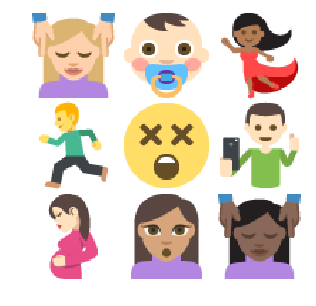

In [5]:
# display 20 random emojis
column_count = 3 # emojis per column
display_count = column_count**2 # total number of emojis to show (aligns neatly if it's a square)

f, axarr = plt.subplots(display_count//column_count, column_count, sharex=True, sharey=True, figsize=(5,5))
for (i, img) in enumerate(random.sample(images, display_count)):
    a = axarr[i%(display_count//column_count), i//(display_count//column_count)]
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

## preprocessing functions

In [6]:
def scale(x, min_val=-1, max_val=1):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    x = x * (max_val - min_val) + min_val
    return x

In [7]:
def get_batches(images, batch_size, shuffle=True):
    images = np.array(images)
    if shuffle:
        idx = np.arange(len(images))
        np.random.shuffle(idx)
        images = images[idx]
    n_batches = len(images)//batch_size
    for i in range(0, len(images), batch_size):
        x = images[i:i+batch_size]
        yield x

In [8]:
print(images[0].shape)

(64, 64, 4)


## define network


In [9]:
# inputs
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=4*4*1024, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 4, 4, 1024))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=training)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 4*4*
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=512, kernel_size=3, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=training)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 16*16*
        
        conv3 = tf.layers.conv2d_transpose(inputs=conv2, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=training)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 32*32*
        
        conv4 = tf.layers.conv2d_transpose(inputs=conv3, filters=64, kernel_size=5, strides=5, padding='SAME', activation=None)
        conv4 = tf.layers.batch_normalization(inputs=conv4, training=training)
        conv4 = tf.maximum(conv4, alpha*conv4)
        # > 32*32*
        
        # Output layer, 64*64*4
        logits = tf.layers.conv2d_transpose(inputs=conv4, filters=output_dim, kernel_size=7, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
        
        return out

In [11]:
def discriminator(x, reuse=False, alpha=0.2):
    def lRU(x, alpha):
        return tf.maximum(x, x * alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        conv1 = tf.layers.conv2d(inputs=x, filters=16, kernel_size=5, strides=2, activation=None)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 16x16x
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=64, kernel_size=4, strides=2, activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 8x8x
        
        conv3 = tf.layers.conv2d(inputs=conv2, filters=256, kernel_size=3, strides=2, activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 4x4x
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=conv3, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [16]:
def train(net, images, epochs, batch_size, print_every=50, show_every=500, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(images, batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 4, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [17]:
# hyper params
real_size = (64,64,4)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 1024
alpha = 0.1
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 9/1024... Discriminator Loss: 1.4415... Generator Loss: 0.6543
Epoch 17/1024... Discriminator Loss: 1.2488... Generator Loss: 0.7881
Epoch 25/1024... Discriminator Loss: 1.1224... Generator Loss: 0.8472
Epoch 34/1024... Discriminator Loss: 1.1459... Generator Loss: 0.8310
Epoch 42/1024... Discriminator Loss: 1.2001... Generator Loss: 0.7760
Epoch 50/1024... Discriminator Loss: 1.1308... Generator Loss: 0.8168
Epoch 59/1024... Discriminator Loss: 1.0634... Generator Loss: 0.8771
Epoch 67/1024... Discriminator Loss: 1.0419... Generator Loss: 0.9330
Epoch 75/1024... Discriminator Loss: 0.9081... Generator Loss: 0.9679
Epoch 84/1024... Discriminator Loss: 0.8792... Generator Loss: 1.0301


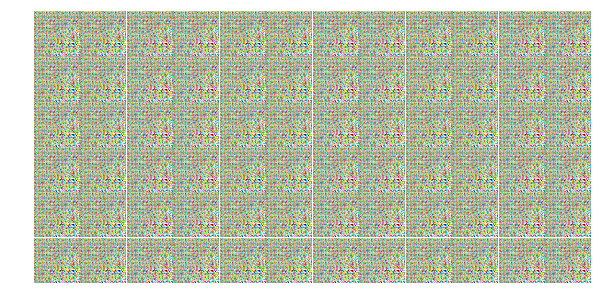

Epoch 92/1024... Discriminator Loss: 0.9048... Generator Loss: 1.0705
Epoch 100/1024... Discriminator Loss: 0.7736... Generator Loss: 1.1315
Epoch 109/1024... Discriminator Loss: 0.6937... Generator Loss: 1.2442
Epoch 117/1024... Discriminator Loss: 0.7436... Generator Loss: 1.2547
Epoch 125/1024... Discriminator Loss: 0.6713... Generator Loss: 1.2878
Epoch 134/1024... Discriminator Loss: 0.6326... Generator Loss: 1.3746
Epoch 142/1024... Discriminator Loss: 0.5360... Generator Loss: 1.3861
Epoch 150/1024... Discriminator Loss: 0.4957... Generator Loss: 1.5613
Epoch 159/1024... Discriminator Loss: 0.4695... Generator Loss: 1.5150
Epoch 167/1024... Discriminator Loss: 0.5086... Generator Loss: 1.5179


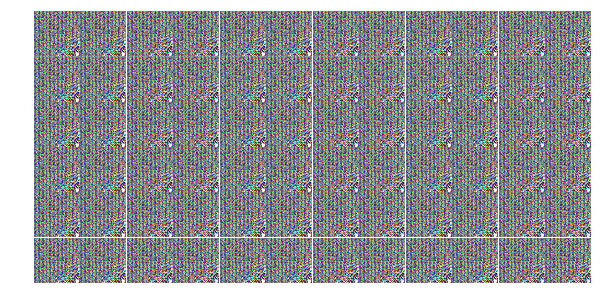

Epoch 175/1024... Discriminator Loss: 0.3978... Generator Loss: 1.7059
Epoch 184/1024... Discriminator Loss: 0.3853... Generator Loss: 1.6773
Epoch 192/1024... Discriminator Loss: 0.3902... Generator Loss: 1.7385
Epoch 200/1024... Discriminator Loss: 0.3443... Generator Loss: 1.8355
Epoch 209/1024... Discriminator Loss: 0.3300... Generator Loss: 1.8649
Epoch 217/1024... Discriminator Loss: 0.3216... Generator Loss: 1.9337
Epoch 225/1024... Discriminator Loss: 0.9342... Generator Loss: 0.9538
Epoch 234/1024... Discriminator Loss: 1.1836... Generator Loss: 0.9657
Epoch 242/1024... Discriminator Loss: 1.1093... Generator Loss: 0.8915
Epoch 250/1024... Discriminator Loss: 1.0573... Generator Loss: 0.8749


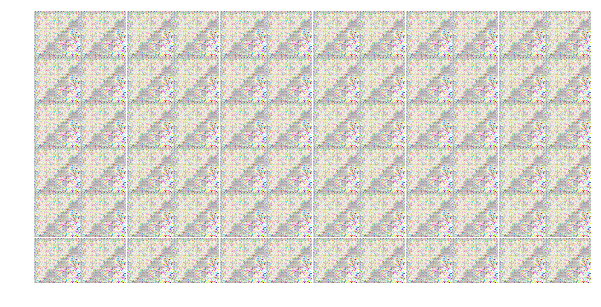

Epoch 259/1024... Discriminator Loss: 1.0478... Generator Loss: 0.9554
Epoch 267/1024... Discriminator Loss: 1.0611... Generator Loss: 0.9353
Epoch 275/1024... Discriminator Loss: 1.0138... Generator Loss: 1.0651
Epoch 284/1024... Discriminator Loss: 1.0145... Generator Loss: 0.9682
Epoch 292/1024... Discriminator Loss: 0.9875... Generator Loss: 0.9575
Epoch 300/1024... Discriminator Loss: 1.0437... Generator Loss: 1.1711
Epoch 309/1024... Discriminator Loss: 0.9326... Generator Loss: 1.0145
Epoch 317/1024... Discriminator Loss: 1.0022... Generator Loss: 1.0173
Epoch 325/1024... Discriminator Loss: 0.9814... Generator Loss: 0.9305
Epoch 334/1024... Discriminator Loss: 0.9485... Generator Loss: 0.9490


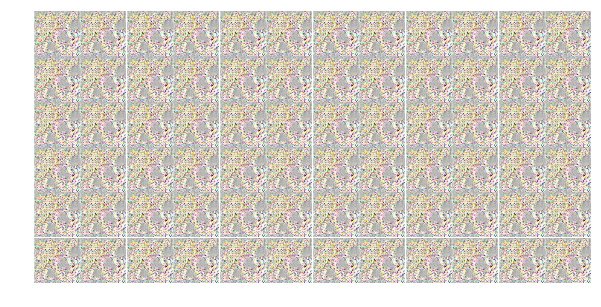

Epoch 342/1024... Discriminator Loss: 0.9905... Generator Loss: 1.0185
Epoch 350/1024... Discriminator Loss: 1.1229... Generator Loss: 1.3952
Epoch 359/1024... Discriminator Loss: 0.8173... Generator Loss: 1.1297
Epoch 367/1024... Discriminator Loss: 0.8032... Generator Loss: 1.0896
Epoch 375/1024... Discriminator Loss: 0.7967... Generator Loss: 1.1964
Epoch 384/1024... Discriminator Loss: 0.8609... Generator Loss: 1.0452
Epoch 392/1024... Discriminator Loss: 0.8814... Generator Loss: 1.2563
Epoch 400/1024... Discriminator Loss: 0.9194... Generator Loss: 1.5460
Epoch 409/1024... Discriminator Loss: 0.8437... Generator Loss: 1.0702
Epoch 417/1024... Discriminator Loss: 0.7850... Generator Loss: 1.0990


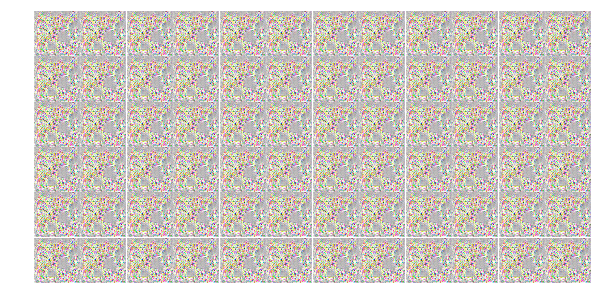

Epoch 425/1024... Discriminator Loss: 0.8078... Generator Loss: 1.3272
Epoch 434/1024... Discriminator Loss: 0.7858... Generator Loss: 1.2302
Epoch 442/1024... Discriminator Loss: 0.7972... Generator Loss: 1.0883
Epoch 450/1024... Discriminator Loss: 0.7549... Generator Loss: 1.1117
Epoch 459/1024... Discriminator Loss: 0.7521... Generator Loss: 1.2075
Epoch 467/1024... Discriminator Loss: 0.6864... Generator Loss: 1.2717
Epoch 475/1024... Discriminator Loss: 0.7238... Generator Loss: 1.3250
Epoch 484/1024... Discriminator Loss: 0.6637... Generator Loss: 1.2564
Epoch 492/1024... Discriminator Loss: 0.6951... Generator Loss: 1.3065
Epoch 500/1024... Discriminator Loss: 0.7309... Generator Loss: 1.1954


Epoch 509/1024... Discriminator Loss: 0.6594... Generator Loss: 1.2382
Epoch 517/1024... Discriminator Loss: 0.8548... Generator Loss: 1.6823
Epoch 525/1024... Discriminator Loss: 0.5998... Generator Loss: 1.3649
Epoch 534/1024... Discriminator Loss: 0.7103... Generator Loss: 1.5549
Epoch 542/1024... Discriminator Loss: 0.6114... Generator Loss: 1.3817
Epoch 550/1024... Discriminator Loss: 0.6455... Generator Loss: 1.1449
Epoch 559/1024... Discriminator Loss: 0.6413... Generator Loss: 1.5367
Epoch 567/1024... Discriminator Loss: 0.6321... Generator Loss: 1.3372
Epoch 575/1024... Discriminator Loss: 0.6094... Generator Loss: 1.4897
Epoch 584/1024... Discriminator Loss: 0.6162... Generator Loss: 1.2596


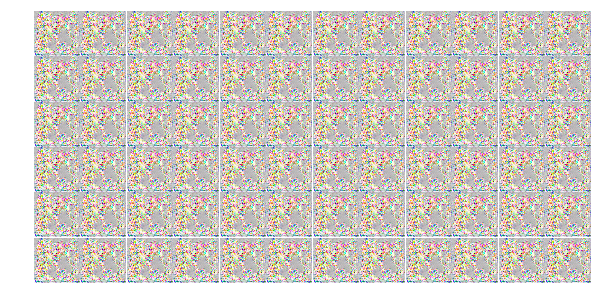

Epoch 592/1024... Discriminator Loss: 0.5829... Generator Loss: 1.4891
Epoch 600/1024... Discriminator Loss: 0.5361... Generator Loss: 1.3140
Epoch 609/1024... Discriminator Loss: 0.7787... Generator Loss: 1.8020
Epoch 617/1024... Discriminator Loss: 0.5583... Generator Loss: 1.7168
Epoch 625/1024... Discriminator Loss: 0.5501... Generator Loss: 1.3271
Epoch 634/1024... Discriminator Loss: 0.4852... Generator Loss: 1.5383
Epoch 642/1024... Discriminator Loss: 0.5067... Generator Loss: 1.4862
Epoch 650/1024... Discriminator Loss: 0.5857... Generator Loss: 1.5553
Epoch 659/1024... Discriminator Loss: 0.6985... Generator Loss: 1.4194
Epoch 667/1024... Discriminator Loss: 0.5937... Generator Loss: 1.7578


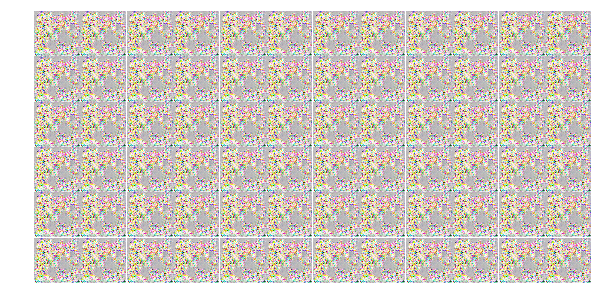

Epoch 675/1024... Discriminator Loss: 0.5814... Generator Loss: 1.7605
Epoch 684/1024... Discriminator Loss: 0.5070... Generator Loss: 1.6343
Epoch 692/1024... Discriminator Loss: 0.6702... Generator Loss: 1.8321
Epoch 700/1024... Discriminator Loss: 0.5019... Generator Loss: 1.6021
Epoch 709/1024... Discriminator Loss: 0.4718... Generator Loss: 1.5162
Epoch 717/1024... Discriminator Loss: 0.6943... Generator Loss: 1.4811
Epoch 725/1024... Discriminator Loss: 0.4994... Generator Loss: 1.5485
Epoch 734/1024... Discriminator Loss: 0.7206... Generator Loss: 1.4647
Epoch 742/1024... Discriminator Loss: 0.5738... Generator Loss: 1.3570
Epoch 750/1024... Discriminator Loss: 0.4209... Generator Loss: 1.6061


Epoch 759/1024... Discriminator Loss: 0.4717... Generator Loss: 1.6409
Epoch 767/1024... Discriminator Loss: 0.4398... Generator Loss: 1.5129
Epoch 775/1024... Discriminator Loss: 0.4176... Generator Loss: 1.6905
Epoch 784/1024... Discriminator Loss: 0.4156... Generator Loss: 1.8134
Epoch 792/1024... Discriminator Loss: 0.4068... Generator Loss: 1.6738
Epoch 800/1024... Discriminator Loss: 0.4378... Generator Loss: 1.6721
Epoch 809/1024... Discriminator Loss: 0.6975... Generator Loss: 2.2383
Epoch 817/1024... Discriminator Loss: 0.6180... Generator Loss: 1.4657
Epoch 825/1024... Discriminator Loss: 0.4052... Generator Loss: 1.6994
Epoch 834/1024... Discriminator Loss: 0.4707... Generator Loss: 1.6948


Epoch 842/1024... Discriminator Loss: 0.3684... Generator Loss: 1.8137
Epoch 850/1024... Discriminator Loss: 0.3645... Generator Loss: 1.9018
Epoch 859/1024... Discriminator Loss: 0.4504... Generator Loss: 1.5737
Epoch 867/1024... Discriminator Loss: 0.3551... Generator Loss: 1.9011
Epoch 875/1024... Discriminator Loss: 0.4998... Generator Loss: 1.9866
Epoch 884/1024... Discriminator Loss: 0.4231... Generator Loss: 1.7747
Epoch 892/1024... Discriminator Loss: 0.4601... Generator Loss: 2.1035
Epoch 900/1024... Discriminator Loss: 0.3267... Generator Loss: 1.8750
Epoch 909/1024... Discriminator Loss: 0.3159... Generator Loss: 1.8953
Epoch 917/1024... Discriminator Loss: 0.3521... Generator Loss: 2.0271


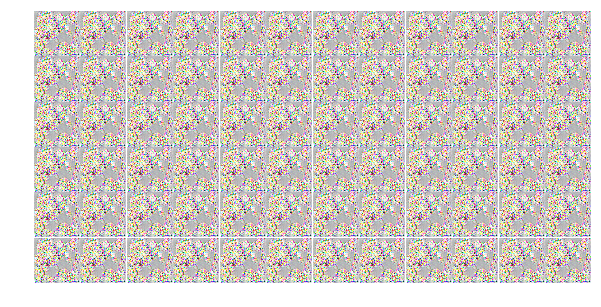

Epoch 925/1024... Discriminator Loss: 0.3712... Generator Loss: 2.0485
Epoch 934/1024... Discriminator Loss: 0.3462... Generator Loss: 1.9425
Epoch 942/1024... Discriminator Loss: 0.3404... Generator Loss: 1.8480
Epoch 950/1024... Discriminator Loss: 0.4032... Generator Loss: 1.9819
Epoch 959/1024... Discriminator Loss: 0.3581... Generator Loss: 2.0239
Epoch 967/1024... Discriminator Loss: 0.3269... Generator Loss: 2.1700
Epoch 975/1024... Discriminator Loss: 0.3885... Generator Loss: 2.1089
Epoch 984/1024... Discriminator Loss: 0.3673... Generator Loss: 2.1495
Epoch 992/1024... Discriminator Loss: 0.2888... Generator Loss: 2.0510
Epoch 1000/1024... Discriminator Loss: 0.2585... Generator Loss: 2.2591


Epoch 1009/1024... Discriminator Loss: 0.2726... Generator Loss: 1.9447
Epoch 1017/1024... Discriminator Loss: 0.2538... Generator Loss: 2.0537


In [18]:
# Load the data and train the network here
losses, samples = train(net, images, epochs, batch_size, figsize=(10,5))

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

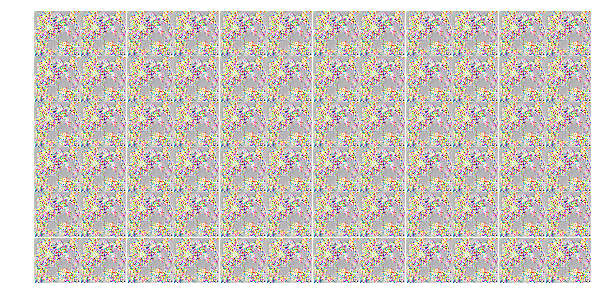

In [20]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))